# Project 3: Image recognizion. (Melanoma)
### Group 7: Emma, Laurits, Malthe, Mads og Jonas


## Loading the Libraries

In [1]:
!apt update
!apt install ffmpeg libsm6 libxext6 -y

!pip install opencv-python
!pip install --upgrade pip

# needed to import cv2 and check photos for bluriness DONT DELETE

Get:1 http://deb.debian.org/debian buster InRelease [121 kB]
Get:2 http://deb.debian.org/debian buster-updates InRelease [51.9 kB]
Get:3 http://security.debian.org/debian-security buster/updates InRelease [65.4 kB]
Get:4 http://deb.debian.org/debian buster/main amd64 Packages [7,907 kB]
Get:5 http://deb.debian.org/debian buster-updates/main amd64 Packages [9,504 B]
Get:6 http://security.debian.org/debian-security buster/updates/main amd64 Packages [272 kB]
Fetched 8,427 kB in 2s (5,373 kB/s)



19 packages can be upgraded. Run 'apt list --upgradable' to see them.



libsm6 is already the newest version (2:1.2.3-1).
libsm6 set to manually installed.
libxext6 is already the newest version (2:1.3.3-1+b2).
libxext6 set to manually installed.
The following additional packages will be installed:
  i965-va-driver intel-media-va-driver libaacs0 libaom0 libasound2
  libasound2-data libass9 libasyncns0 libavc1394-0 libavcodec58 libavdevice58
  libavfilter7 libavformat58 libavresample4 libavutil5

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import fyp2021p3_group00_functions as util
import pandas as pd
from skimage import morphology
from skimage import filters
from skimage.morphology import opening
import cv2
from sklearn.model_selection import train_test_split
from skimage.exposure import is_low_contrast
from scipy.ndimage import rotate

## Functions

In [3]:
def check_quality(dictionary_, image_id_jpg):
    
    """ A Function that returns the number of pixels in an image that can
    be used to check whether the image is low or high quality"""

    im = plt.imread(dictionary_[image_id_jpg])
    resolution = im.shape
    num_of_pixels = resolution[0]*resolution[1]
    return num_of_pixels

In [4]:
def low_quality_pictures(resolution, dictionary_):
    not_fine = 0
    fine = 0
    popped_image = []

    for i in dictionary_:   
        x = check_quality(dictionary_, str(i))
        if x >= resolution:
            fine += 1
        else: 
            not_fine += 1
            popped_image.append(i)

    # then we pop the images from the dictionary PICTURES that are low quality 
    for i in popped_image:
        if i in dictionary_:
            dictionary_.pop(i)

    print('Fine: {0}, Not fine: {1}'.format(fine, not_fine))
    print('Image popped from the dict: {0}'.format(popped_image))

In [5]:
def bluriness(dictionary_):
    
    """This function takes a dictionary and checks whether the images
    in the dictionary are blurry or sharp and then removes the blurry images
    from the dictionary."""

    blurry_images = []
    not_blurry = 0
    blurry = 0
    for key, value in dictionary_.items():   
        x = cv2.imread(str(value))
        v = cv2.Laplacian(x, cv2.CV_64F).var()
        if v > 10:
            not_blurry += 1
        else: 
            blurry += 1
            blurry_images.append(key)

# now we delete the images from the dictionary that are blurry
    for i in blurry_images:
        dictionary_.pop(i)
        temp = str(i)
        dictionary_.pop(temp[:-4]+"_segmentation.png")

    print('Not Blurry: {0}'.format(not_blurry))
    print('Blurry: {0}'.format(blurry))
    print("Blurry Images: {0}".format(blurry_images))

In [6]:
def contrast(dictionary_):

    """ The function takes a dictionary of images with the path as a value 
	to input and checks the contrast of the image"""

    high = 0
    low = 0
    low_ = []
    for key, value in dictionary_.items():
        x = cv2.imread(str(value))
        y = is_low_contrast(x)
        if y == True:
            low += 1
            low_.append(key)
        else:
            high += 1
            
    #Removes the low contrast from the PICTURES
    for i in low_:
        dictionary_.pop(i)

    print('Number of Images with High Contrast: {0}'.format(high))
    print('Number of Images with Low Contrast: {0}'.format(low))
    print("Images with Low Contrast: {0}".format(low_))

In [24]:
def get_mask_size(mask):
    """Finding the min and max values for the mask"""
    i, j = np.where(mask)

    x_min = j.min()
    x_max = j.max()
    y_min = i.min()
    y_max = i.max()
    return x_min, x_max, y_min, y_max
    

## Loading the data

In [7]:
# First we make the path to the data
PATH = {}
PATH["data"] ="../data"

#print(PATH)
#Then we load the path for all the diffirent as keys to their names.
PICTURES = {}
for path, subdirs, files in os.walk(PATH["data"]):
    for picture in files:
        # Making sure that we exclude the .csv from the dictionary, to only include images (ie. png and jpg files)
        if not str(picture).count(".csv", (len(picture) - 4),len(picture)):
            PICTURES[picture] = os.path.normpath(os.path.join(path, picture))

print(PICTURES)
# Remove a last file from the PICTURES dictonary
PICTURES.pop(".DS_Store")

images = pd.read_csv("../data/example_ground_truth.csv")
images['id'] = images['image_id']
image_way = pd.DataFrame.from_dict(PICTURES, orient='index')
image_way['id'] = image_way.index
for number, name in enumerate(iterable = image_way['id']):
    image_way['id'][number] = name[0:12]
image_merge = images.merge(image_way, left_on ='image_id' , right_on = 'id', how = 'outer')
image_merge['healthy'] = 1-image_merge['melanoma']-image_merge['seborrheic_keratosis']
image_merge = image_merge.rename(columns ={0: 'path'})
image_merge['mask'] = image_merge['path'].str.contains('png')
image_merge['raw'] = image_merge['path'].str.contains('jpg')
# Reworking images to contain name and helath of all the images to use later.
images = images.dropna(axis=0)
images = images[images['seborrheic_keratosis']!= 1]


{'.DS_Store': '../data/example_image/.DS_Store', 'ISIC_0012222_segmentation.png': '../data/example_segmentation/ISIC_0012222_segmentation.png', 'ISIC_0007332_segmentation.png': '../data/example_segmentation/ISIC_0007332_segmentation.png', 'ISIC_0012746_segmentation.png': '../data/example_segmentation/ISIC_0012746_segmentation.png', 'ISIC_0013010_segmentation.png': '../data/example_segmentation/ISIC_0013010_segmentation.png', 'ISIC_0013215_segmentation.png': '../data/example_segmentation/ISIC_0013215_segmentation.png', 'ISIC_0003539_segmentation.png': '../data/example_segmentation/ISIC_0003539_segmentation.png', 'ISIC_0015372_segmentation.png': '../data/example_segmentation/ISIC_0015372_segmentation.png', 'ISIC_0014712_segmentation.png': '../data/example_segmentation/ISIC_0014712_segmentation.png', 'ISIC_0012660_segmentation.png': '../data/example_segmentation/ISIC_0012660_segmentation.png', 'ISIC_0013561_segmentation.png': '../data/example_segmentation/ISIC_0013561_segmentation.png', '

# Task 0: Explore the Data

Go through the data (csv file, images, segmentations) that you have available
to understand what’s available to you, and write a brief description. Decide if
this data is sufficient, or if cleaning is needed. For example, what do you do with
the images that are malignant (cancer), but not of the class you want to focus
on? Are there images of low quality? Etc. You are allowed to search for and add
other public dataset, to this set of images.

##### Description of Data: 
The data includes 150 images of skin lesions and then another 150 images of the same images in segmentations, whereby the image is zoomed in. Besides this the data also includes the Superpixel of some of the images. 

In [8]:
# Loading the data into a dataframe and classifying based on class
image_info = pd.read_csv("../data/example_ground_truth.csv")
cancer_free = image_info[(image_info['melanoma']== 0) & (image_info['seborrheic_keratosis']==0)]
melanoma = image_info[image_info['melanoma'] == 1]
keratosis = image_info[image_info['seborrheic_keratosis']==1]

#image_info
print("image_info: {0}, cancer_free: {1}, melanoma: {2}, keratosis: {3}"
.format(image_info.shape, cancer_free.shape, melanoma.shape, keratosis.shape))


image_info: (150, 3), cancer_free: (78, 3), melanoma: (30, 3), keratosis: (42, 3)


In [9]:
# put keratosis image id's into a list to use later
list_keratosis = []
for i in keratosis["image_id"]:
    list_keratosis.append(i)

# deleting the keratosis images in the dictionary PICTURES
# length of dictiionary has changed from 357 to 275 images
for i in list_keratosis:
    n = (i + '.jpg')
    x = (i + '_segmentation.png')
    y = (i + '_superpixels.png')
    if n in PICTURES:
        PICTURES.pop(n)
    if x in PICTURES:
        PICTURES.pop(x)
    if y in PICTURES:
        PICTURES.pop(y)

#now we remove the superpixels
super_pixels = []

for i in PICTURES:
   if '_superpixels.png' in i:
        super_pixels.append(i)

for i in super_pixels:
    PICTURES.pop(i)

print(len(PICTURES))

217


## Checking for duplicates

In [10]:
""" First we check for duplicates"""

#Checks for duplicated image IDs in image_info
image_id = set()
not_unique_id = 0
for i in image_info['image_id']:
    if i not in image_id:
        image_id.add(i)
    else:
        not_unique += 1
print('Number of duplicates image id: {0}'.format(not_unique_id))

#Checks that there is no duplicates in the pictures
image_unique = set()
not_unique_image = 0
for i in PICTURES:
    if i not in image_unique:
        image_unique.add(i)
    else:
        not_unique_image += 1
print('Number of duplicates images: {0}'.format(not_unique_image))

"""Then we checks that all ID's has a corresponding image, and vice versa"""

# cancer free and melanoma image id's is loaded into sets
cf = set(i for i in cancer_free['image_id'])
mel = set(i for i in melanoma['image_id'])

no_image = set()

#Checks that all IDs in image info is in example folders
for i in cf:
    n = (i + '.jpg')
    if n not in PICTURES:
        no_image.add(i)

for i in mel:
    n = (i + '.jpg')
    if n not in PICTURES:
        no_image.add(i)

print('No image: {0}'.format(len(no_image)))

#Checks that all pictures in example image folder has a image ID in image_info
no_ID = set()

for i in PICTURES:
    x = i[0:12] #The first 12 characters is the ID
    if x not in image_id :
        no_ID.add(i)
print('No ID in image_info: {0}'.format(len(no_ID)))


Number of duplicates image id: 0
Number of duplicates images: 0
No image: 0
No ID in image_info: 0


## Cleaning the Data

In the following cell the dataset of images is cleaned for the following three criteria:

- Resolution
- Blurriness/Sharpness
- Contrast

The images that do not fit the criteria are removed from the image dictionary.

In [11]:
## Checking RESOLUTION
sd = 600*450
low_quality_pictures(sd, PICTURES)

Fine: 217, Not fine: 0
Image popped from the dict: []


In [12]:
## Checking BLURRINESS/SHARPNESS
bluriness(PICTURES)

Not Blurry: 212
Blurry: 5
Blurry Images: ['ISIC_0012400.jpg', 'ISIC_0013082.jpg', 'ISIC_0012288.jpg', 'ISIC_0014162.jpg', 'ISIC_0013104.jpg']


Now we will check the colour quality by checking the contrast level.

To check the contrast of an image we use the function is_low_contrast from the library skimage.exposure. 

https://scikit-image.org/docs/dev/api/skimage.exposure.html#re0c68370bb9d-1

In [13]:
## Checking CONTRAST
contrast(PICTURES)

Number of Images with High Contrast: 205
Number of Images with Low Contrast: 2
Images with Low Contrast: ['ISIC_0013527_segmentation.png', 'ISIC_0012965_segmentation.png']


In [14]:
print(len(PICTURES))

205


## External Data

First we load the data and clean it with the same criteria used on the previous data in the dictionary named PICTURES.

In [135]:
# First we make the path to the data
PATH = {}
PATH["external data"] ="../external_data/external_data"

#Then we load the path for all the diffirent as keys to their names.
EXTERNAL = {}
for path, subdirs, files in os.walk(PATH["external data"]):
    for picture in files:
        # Making sure that we exclude the .csv from the dictionary, to only include images (ie. png and jpg files)
        if not str(picture).count(".csv", (len(picture) - 4),len(picture)):
            EXTERNAL[picture] = os.path.normpath(os.path.join(path, picture))

EXTERNAL.pop('.DS_Store')
print(len(EXTERNAL))

# Loading the data into a dataframe and classifying based on class
external_image_info = pd.read_csv("../external_data/ISIC-2017_Training_Part3_GroundTruth.csv")
external_cancer_free = external_image_info[(external_image_info['melanoma']== 0) & (external_image_info['seborrheic_keratosis']==0)]
external_melanoma = external_image_info[external_image_info['melanoma'] == 1]
external_keratosis = external_image_info[external_image_info['seborrheic_keratosis']==1]

#image_info
print("image_info: {0}, cancer_free: {1}, melanoma: {2}, keratosis: {3}"
.format(external_image_info.shape, external_cancer_free.shape, external_melanoma.shape, external_keratosis.shape))

919
image_info: (2000, 3), cancer_free: (1372, 3), melanoma: (374, 3), keratosis: (254, 3)


The external data is checked for duplicates

In [136]:
#Checks for duplicated image IDs in image_info
image_id = set()
not_unique_id = 0
for i in external_image_info['image_id']:
    if i not in image_id:
        image_id.add(i)
    else:
        not_unique += 1
print('Number of duplicates image id: {0}'.format(not_unique_id))

#Checks that there is no duplicates in the pictures
image_unique = set()
not_unique_image = 0
for i in EXTERNAL:
    if i not in image_unique:
        image_unique.add(i)
    else:
        not_unique_image += 1
print('Number of duplicates images: {0}'.format(not_unique_image))

"""Then we checks that all ID's has a corresponding image, and vice versa"""

# cancer free and melanoma image id's is loaded into sets
mel = set(i for i in external_image_info['image_id'])

no_image = set()

#Checks that all IDs in image info is in example folders
for i in mel:
    n = (i + '.jpg')
    if n not in EXTERNAL:
        no_image.add(i)

print('No image: {0}'.format(len(no_image)))

#Checks that all pictures in example image folder has a image ID in image_info
no_ID = set()

for i in EXTERNAL:
    x = i[0:12] #The first 12 characters is the ID
    if x not in image_id:
        no_ID.add(i)

print('No ID in image_info: {0}'.format(len(no_ID)))

Number of duplicates image id: 0
Number of duplicates images: 0
No image: 1541
No ID in image_info: 0


External data is checked for resolution quality, blurriness, and contrast quality

In [137]:
sd = 720 * 480
low_quality_pictures(sd, EXTERNAL)

Fine: 919, Not fine: 0
Image popped from the dict: []


In [138]:
bluriness(EXTERNAL)

Not Blurry: 906
Blurry: 13
Blurry Images: ['ISIC_0001105.jpg', 'ISIC_0001102.jpg', 'ISIC_0001142.jpg', 'ISIC_0000240.jpg', 'ISIC_0001126.jpg', 'ISIC_0000391.jpg', 'ISIC_0000388.jpg', 'ISIC_0000379.jpg', 'ISIC_0000377.jpg', 'ISIC_0000245.jpg', 'ISIC_0000548.jpg', 'ISIC_0000378.jpg', 'ISIC_0000384.jpg']


In [139]:
contrast(EXTERNAL)

Number of Images with High Contrast: 893
Number of Images with Low Contrast: 0
Images with Low Contrast: []


Now the external data is seperated 50/50 so that 50% can be used to test the model again, and the other 50% can provide the results needed.

In [20]:
x = [i for i in external_melanoma['image_id'] ]
melanoma_dict = {}


for key, value in EXTERNAL.items():
    if key[0:12] in x:
        melanoma_dict[key] = value

y = [i for i in external_cancer_free['image_id'] ]
cancer_free_dict = {}

for key, value in EXTERNAL.items():
    if key[0:12] in y:
        cancer_free_dict[key] = value

        
external_melanoma['mask'] = external_melanoma['image_id']+'_segmentation.png'
external_melanoma['raw'] = external_melanoma['image_id']+'.jpg'
external_melanoma
# melonoma_way = pd.DataFrame.from_dict(melanoma_dict)
# melonoma_way

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,image_id,melanoma,seborrheic_keratosis,mask,raw
2,ISIC_0000002,1.0,0.0,ISIC_0000002_segmentation.png,ISIC_0000002.jpg
4,ISIC_0000004,1.0,0.0,ISIC_0000004_segmentation.png,ISIC_0000004.jpg
12,ISIC_0000013,1.0,0.0,ISIC_0000013_segmentation.png,ISIC_0000013.jpg
21,ISIC_0000022,1.0,0.0,ISIC_0000022_segmentation.png,ISIC_0000022.jpg
25,ISIC_0000026,1.0,0.0,ISIC_0000026_segmentation.png,ISIC_0000026.jpg
...,...,...,...,...,...
1991,ISIC_0015190,1.0,0.0,ISIC_0015190_segmentation.png,ISIC_0015190.jpg
1992,ISIC_0015200,1.0,0.0,ISIC_0015200_segmentation.png,ISIC_0015200.jpg
1993,ISIC_0015204,1.0,0.0,ISIC_0015204_segmentation.png,ISIC_0015204.jpg
1994,ISIC_0015219,1.0,0.0,ISIC_0015219_segmentation.png,ISIC_0015219.jpg


# Task 1: Implement Two Features
Choose one of the ABC (Asymetry, Border or Color) features and implement a function to measure it for one
image. While you are doing this, you might want to create “toy” images where
you already know the results, for example a circle should be less asymmetric
than an ellipse, etc.
Once you are satisfied with your implementations, run them on all your
images, and examine the feature distributions for each class, for example using
scatter plots. Do you see differences between the classes?

## Asymmetry

In [80]:
import math

def test_asymmetry(mask):

    x_min, x_max, y_min, y_max = get_mask_size(mask)

    mask_cropped = mask[y_min:y_max, x_min:x_max]

    # for angle in range(0,180, 45):
        # print(angle)

        # rotated_mask = rotate(mask_cropped,angle)
        
        # x_min, x_max, y_min, y_max = get_mask_size(rotated_mask)

        # View left half of the x-axis
    x_half = (x_max - x_min) / 2 # Gives us the middle 

    if x_half.is_integer():
        mask_x_half_left = mask_cropped[:, :int(x_half)]
        mask_x_half_right = mask_cropped[:, int(x_half):]
    else:
        mask_x_half_left = mask_cropped[:, :int(x_half)+1]
        mask_x_half_right = mask_cropped[:, int(x_half):]

    mask_x_half_right_flipped = np.fliplr(mask_x_half_right)

    x_diff = mask_x_half_left - mask_x_half_right_flipped

    # Fold in half y-axis
    y_half = (y_max - y_min) / 2 # Gives us the middle 

    if y_half.is_integer():
        mask_y_half_left = mask_cropped[:int(y_half), :]
        mask_y_half_right = mask_cropped[int(y_half):, :]
    else:
        mask_y_half_left = mask_cropped[:int(y_half)+1, :]
        mask_y_half_right = mask_cropped[int(y_half):, :]


    mask_y_half_right_flipped = np.flipud(mask_y_half_right)

    y_diff = mask_y_half_left - mask_y_half_right_flipped

    # Calculing diff

    gray1 = np.count_nonzero(x_diff == 0)
    non_gray1 = np.count_nonzero(x_diff)

    score_x = non_gray1/gray1 * 100

    gray1 = np.count_nonzero(y_diff == 0)
    non_gray1 = np.count_nonzero(y_diff)

    score_y = non_gray1/gray1 * 100

    return score_x if score_x > score_y else score_y

In [148]:
way = melanoma_dict['ISIC_0010329_segmentation.png']

mask = plt.imread('../data/example_segmentation/ISIC_0004337_segmentation.png')

mask = plt.imread(way)
print(test_asymmetry(mask))


29.21294764016681


In [155]:

# x_min, x_max, y_min, y_max = get_mask_size(mask)

# mask_cropped = mask[y_min-5:y_max+5, x_min-5:x_max+5]

# # View left half of the x-axis
# x_half = (x_max - x_min) / 2 + x_min # Gives us the middle 

# mask_x_half_left = mask[y_min-5:y_max+5, x_min-5:int(x_half)]
# mask_x_half_right = mask[y_min-5:y_max+5, int(x_half):x_max+5]

# mask_x_half_right_flipped = np.fliplr(mask_x_half_right)

# x_diff = mask_x_half_left - mask_x_half_right_flipped

# # Fold in half y-axis
# y_half = (y_max - y_min) / 2 + y_min # Gives us the middle 

# mask_y_half_left = mask[y_min-5:int(y_half), x_min-5:x_max+5]
# mask_y_half_right = mask[int(y_half):y_max+5, x_min-5:x_max+5]

# mask_y_half_right_flipped = np.flipud(mask_y_half_right)

# y_diff = mask_y_half_left - mask_y_half_right_flipped


# # Calculing diff

# gray1 = np.count_nonzero(x_diff == 0)
# non_gray1 = np.count_nonzero(x_diff)

# print(non_gray1)

# gray1 = np.count_nonzero(y_diff == 0)
# non_gray1 = np.count_nonzero(y_diff)

# print(non_gray1)

# # Displaying the output for vertical
# fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(7, 4))
# axes[0].imshow(mask_cropped,cmap='gray')
# axes[1].imshow(mask_cropped_rotate, cmap="gray")
# axes[2].imshow(mask_x_half_left,cmap='gray')
# axes[3].imshow(mask_x_half_right,cmap='gray')
# axes[4].imshow(x_diff,cmap='gray')
# fig.tight_layout()

# fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(7, 4))
# axes[0].imshow(mask_cropped,cmap='gray')
# axes[1].imshow(mask_y_half_left,cmap='gray')
# axes[2].imshow(mask_y_half_right,cmap='gray')
# axes[3].imshow(y_diff,cmap="gray")
# fig.tight_layout()

# # Flipping the mask vertically and horizontally
# mask_ver = np.fliplr(mask_cropped)
# mask_hor = np.flipud(mask_cropped)





# # Displaying the output for horizontal
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))
# axes[0].imshow(mask_cropped,cmap='gray')
# axes[1].imshow(mask_hor,cmap='gray')
# fig.tight_layout()

In [153]:
# Subtract the masks from each other to get the difference

#image_diff1 = mask_cropped - mask_ver
#image_diff2 = mask_cropped - mask_hor

# Counting number of gray and non-gray pixels
#gray1 = np.count_nonzero(image_diff1 == 0)
#non_gray1 = np.count_nonzero(image_diff1)

#print(non_gray1)

#gray2 = np.count_nonzero(image_diff2 == 0)
#non_gray2 = np.count_nonzero(image_diff2)

#print(non_gray2)

#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))
#axes[0].imshow(image_diff1,cmap='gray')
#axes[1].imshow(image_diff2,cmap='gray')
#fig.tight_layout()

In [154]:
# Inspect an entire np array (only consists of -1, 0, 1)
#import sys
#np.set_printoptions(threshold=sys.maxsize)
#image_diff1

# Counting number of gray and non-gray pixels
#gray1 = np.count_nonzero(image_diff1 == 0)
#non_gray1 = np.count_nonzero(image_diff1)

#gray2 = np.count_nonzero(image_diff2 == 0)
#non_gray2 = np.count_nonzero(image_diff2)

#print("Left picture")
#print("Number of gray pixels is " + str(gray1))
#print("Number of non-gray pixels is " + str(non_gray1))
#print("Number of gray pixels compared to non-gray pixels is " + str(gray1 / non_gray1))
#print(" ")
#print("Right picture")
#print("Number of gray pixels is " + str(gray2))
#print("Number of non-gray pixels is " + str(non_gray2))
#print("Number of gray pixels compared to non-gray pixels is " + str(gray2 / non_gray2))
#print(" ")

## Border

In [26]:
from skimage.morphology import opening
def find_border(mask):
    """Returns a ratio between the surcumfrance and the area of a mask. 
    It returns 0 for a perfect circle, and increasingly higher returns for larger 
    surcomfrance compared with area."""
    # Using the fact that all values within the area of the mask is 1, 
    # the area is equal to the sum of the mask
    ones = np.sum(mask)
    # Applying a gausian border to find the surcumfrance
    border = filters.difference_of_gaussians(mask,1) 
    # Reducing the size of the border.

    border = np.where((border < -0.01) & (border > 0.01), 1, border)
    border = np.where(border < 0.01 , 0, border)


    surcumfrance = np.sum(border)

    #plt.imshow(border, cmap='gray')

    Compactness = surcumfrance**2/ones*12


    return(Compactness)

find_border(mask)
test_square = np.pad(np.ones((100,200)), pad_width = 5, constant_values=0)
test_big_square = np.pad(np.ones((1000,2000)), pad_width = 5, constant_values=0)
# find_border(test_big_square)
# find_border(test_square)

# Idea from https://stackoverflow.com/questions/10031580/how-to-write-simple-geometric-shapes-into-numpy-arrays
xx, yy = np.mgrid[:200, :200]

circle = (xx - 100) ** 2 + (yy - 100) ** 2
circle1 = np.where(circle < 1500, 1, circle)
circle1 = np.where(circle1 > 1, 0, circle1)
circle2 = np.where(circle < 1850, 1, circle)
circle2 = np.where(circle2 > 1, 0, circle2)
# find_border(circle1)
# find_border(circle2)





In [321]:
def test_color2(image, mask):
    # Have to do this in order for skimage to work properly
    mask = img_as_float(mask[::2, ::2])
    image = img_as_float(image[::2, ::2])

    segments = slic(image, n_segments= 20, compactness=3,sigma= 5, max_iter=10, mask=mask, convert2lab=True)

    plt.imshow(segments)
    plt.show()

    def sp_idx(s, index = True):
        u = np.unique(s)
        return [np.where(s == i) for i in u]

    blended_colors = label2rgb(segments, image, kind="avg", bg_label=0) # returns RGB floats / RGB Normalized 
    # To convert the normalized RGB back to RGB, we have to multiply the colour channel with 255 and round.

    plt.imshow(blended_colors)

    print(len(blended_colors))

    # Need to figure out a way to point to each segment.
    #                       x   y  R = 0/G = 1/B = 2
    # print(blended_colors[80][140][0])

    print(segments.shape)

    superpixel_list = sp_idx(segments)
    #superpixel      = [image[blended_colors] for idx in blended_colors]

    print(0.47518085 * 255)

    print(len(superpixel_list))

    for i in superpixel_list:
        print(np.unique(i[0]))

    #print(superpixel_list[1])

    print(r)

    # for colour in liste:
    #     print(colour[0])
    #     r = colour[0] * 255
    #     g = colour[1] * 255
    #     b = colour[2] * 255
    #     print(r,g,b)
    

    specific_colors = np.unique(blended_colors)

    # Average of the colors of the lesion
    # Subtract the highest color spot from the average

    print(specific_colors)

    skin_color_treshold = 0.3
    to_avg = []

    for spot_color in specific_colors:
        if spot_color > skin_color_treshold:
            to_avg.append(spot_color)

    highest = specific_colors[-1]
    average = sum(to_avg) / len(to_avg)

    print("here")

    return highest - average

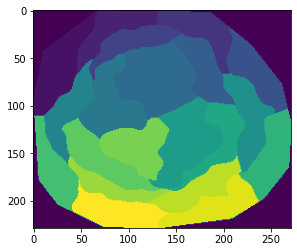

229
(229, 271)
121.17111675
21
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228]
[  0   1   2   3   4   5   6   7   8   

NameError: name 'r' is not defined

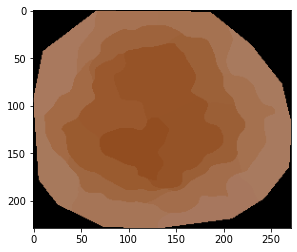

In [322]:

# image = plt.imread('../white.jpg')
# image = image[100:500,200:600]

# diff = test_color2(image)
# print(diff)

# Cancer free

mask = plt.imread('../data/example_segmentation/ISIC_0004337_segmentation.png')
x_min, x_max, y_min, y_max = get_mask_size(mask)

mask = mask[y_min:y_max, x_min:x_max]

image = plt.imread('../data/example_image/ISIC_0004337.jpg')
image = image[y_min:y_max, x_min:x_max]

diff = test_color2(image, mask)
print(diff)

print(round(0.66471408 * 255))

# Cancer

# mask = plt.imread('../data/example_segmentation/ISIC_0014809_segmentation.png')
# x_min, x_max, y_min, y_max = get_mask_size(mask)
# mask = mask[y_min:y_max, x_min:x_max]

# image = plt.imread('../data/example_image/ISIC_0014809.jpg')
# image = image[y_min:y_max, x_min:x_max]

# plt.imshow(mask)

#[0.58997018 0.32687186 0.15325907]

# diff = test_color2(image, mask)
# print(diff)

## Colour

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# from skimage.data import astronaut
# from skimage.color import rgb2gray
from skimage.color import label2rgb
# from skimage.filters import sobel
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

def test_color(image, mask):
    # Have to do this in order for skimage to work properly
    mask = img_as_float(mask[::2, ::2])
    image = img_as_float(image[::2, ::2])

    segments = slic(image, n_segments= 20, compactness=3,sigma= 5, max_iter=10, mask=mask)

    blended_colors = label2rgb(segments, image, kind="avg", bg_label=0)

    specific_colors = np.unique(blended_colors)

    # Average of the colors of the lesion
    # Subtract the highest color spot from the average

    skin_color_treshold = 0.3
    to_avg = []

    for spot_color in specific_colors:
        if spot_color > skin_color_treshold:
            to_avg.append(spot_color)

    highest = specific_colors[-1]
    average = sum(to_avg) / len(to_avg)

    return highest - average

    # -----

    # Okay method to test for cancer

    # for i in range(-2, -10, -1): # Check the color difference from the 9 highest valued segments
    #     #print(highest - specific_colors[i])
    #     if ((highest - specific_colors[i]) > threshold):
    #         print("Cancerous")
    #         break


    # fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    # axes[0][0].imshow(mask)
    # axes[0][1].imshow(image)
    # axes[1][0].imshow(blended_colors)
    # axes[1][1].imshow(mark_boundaries(image, segments, color=(0,0,0)))
    # fig.tight_layout()

# # Threshold
# threshold_for_cancer = 0.18

# # Cancer free
# x_min, x_max, y_min, y_max = get_mask_size('../data/example_segmentation/ISIC_0004337_segmentation.png')

# mask = plt.imread('../data/example_segmentation/ISIC_0004337_segmentation.png')
# mask = mask[x_min:x_max, y_min:y_max]

# image = plt.imread('../data/example_image/ISIC_0004337.jpg')
# image = image[x_min:x_max, y_min:y_max]

# diff = test_color(image, mask)

# if diff > threshold_for_cancer:
#     print("Cancerous")
# else:
#     print("Not Cancerous")
# # ---------- # ----------

# x_min, x_max, y_min, y_max = get_mask_size(mask)

# mask = plt.imread('../data/example_segmentation/ISIC_0013010_segmentation.png')
# mask = mask[x_min:x_max, y_min:y_max]

# image = plt.imread('../data/example_image/ISIC_0013010.jpg')
# image = image[x_min:x_max, y_min:y_max]

# diff = test_color(image, mask)

# if diff > threshold_for_cancer:
#     print("Cancerous")
# else:
#     print("Not Cancerous")

# Cancer
# mask = plt.imread('../data/example_segmentation/ISIC_0014809_segmentation.png')
# mask = mask[1000:4500, 1500:5000]

# image = plt.imread('../data/example_image/ISIC_0014809.jpg')
# image = image[1000:4500, 1500:5000]

# test_color(image, mask)
# --------
# mask = plt.imread('../data/example_segmentation/ISIC_0013663_segmentation.png')
# mask = mask[0:2450, 1300:3100]

# image = plt.imread('../data/example_image/ISIC_0013663.jpg')
# image = image[0:2450, 1300:3100]

# test_color(image, mask)


# Task 2: Predict the diagnosis
Split your data so that you are have training data and hold-out test data. Use
the training data to train different classifiers and investigate their parameters.
Once you made a choice, evaluate your classifier on the hold-out test data. Think
of different metrics you can use, and different ways to present your results.

## Preparing machine learning
The data is split into training and the data that will be learned on, and the features are extracted

In [ ]:
counts, unique = np.unique(y_train, return_counts=True)
print(counts, unique)

[0. 1.] [56 19]


In [ ]:
# This takes a very long time. Run this at your own risk...

#x_train, x_test, y_train, y_test = train_test_split(images['image_id'], images['melanoma'], test_size = 0.3, random_state = 4)
x_train2, x_test2, y_train2, y_test2 = train_test_split(images['image_id'], images['melanoma'], test_size = 0.3, random_state = 4)

x_train_data = []
for test, picture in enumerate(x_train):
    test_picture = list(image_merge['path'][image_merge['image_id'] == picture])
    print("name_found")
    #print(test_picture)
    # Load in the mask and picture
    temp = []
    mask = plt.imread(test_picture[0])
    raw_pict = plt.imread(test_picture[-1])
    print("Picture loaded")
    # Finding the boundaries of the mask.
    x_min, x_max, y_min, y_max = get_mask_size(mask)
    # 
    if x_min > 5:
        mask = mask[:, x_min-5:]
        raw_pict = raw_pict[:, x_min-5:]
    if y_min > 5:
        mask = mask[y_min-5:,:]
        raw_pict = raw_pict[y_min-5:,:]    
    if x_max < mask.shape[1]:
        mask = mask[:,:x_max+5]
        raw_pict = raw_pict[:,:x_max+5]
    if  y_max < mask.shape[0]:
        mask = mask[:y_max+5,:]
        raw_pict = raw_pict[:y_max+5,:]
        temp.append(test_asymmetry(mask))
    temp.append(find_border(mask))
    temp.append(test_color(raw_pict,mask))
    x_train_data.append(temp)
    print(temp)
    
x_test_data = []
for test, picture in enumerate(x_test):
    test_picture = list(image_merge['path'][image_merge['image_id'] == picture])
    #print(test_picture)
    # Load in the mask and picture
    temp = []
    mask = plt.imread(test_picture[0])
    raw_pict = plt.imread(test_picture[-1])
    # Finding the boundaries of the mask.
    x_min, x_max, y_min, y_max = get_mask_size(mask)
    # Only applying the border if the 
    if x_min > 5:
        mask = mask[:, x_min-5:]
        raw_pict = raw_pict[:, x_min-5:]
    if y_min > 5:
        mask = mask[y_min-5:,:]
        raw_pict = raw_pict[y_min-5:,:]    
    if x_max < mask.shape[1]:
        mask = mask[:,:x_max+5]
        raw_pict = raw_pict[:,:x_max+5]
    if  y_max < mask.shape[0]:
        mask = mask[:y_max+5,:]
        raw_pict = raw_pict[:y_max+5,:]
    try:
        temp.append(test_asymmetry(mask))
    except: 
        temp.append(-1)
    temp.append(find_border(mask))
    temp.append(test_color(raw_pict,mask))

    x_test_data.append(temp)

    print(temp)

# print(x_train_data)

SyntaxError: invalid syntax (<ipython-input-321-ba3ef669e796>, line 62)

In [129]:
melonoma_set = set()
for key in melanoma_dict:
    melonoma_set.add(key[:12])

health_set = set()
for key in cancer_free_dict:
    health_set.add(key[:12])


In [133]:
# melanoma_list = [] 
# for picture in melonoma_set:
#     try:
#         test_picture = melanoma_dict[picture+".jpg"]
#         test_mask = melanoma_dict[picture+"_segmentation.png"]
#         #print(test_picture)
#         # Load in the mask and picture
#         temp = []
#         mask = plt.imread(test_mask)
#         raw_pict = plt.imread(test_picture)
#         # Finding the boundaries of the mask.
#         x_min, x_max, y_min, y_max = get_mask_size(mask)
#         # 
#         if x_min > 5:
#             mask = mask[:, x_min-3:]
#             raw_pict = raw_pict[:, x_min-3:]
#         if y_min > 5:
#             mask = mask[y_min-3:,:]
#             raw_pict = raw_pict[y_min-3:,:]    
#         if x_max < mask.shape[1]:
#             mask = mask[:,:x_max+3]
#             raw_pict = raw_pict[:,:x_max+3]
#         if  y_max < mask.shape[0]:
#             mask = mask[:y_max+3,:]
#             raw_pict = raw_pict[:y_max+3,:]
#         temp.append(test_asymmetry(mask))
#         temp.append(find_border(mask))
#         temp.append(test_color(raw_pict,mask))
#         melanoma_list.append(temp)
#         print(temp)
#     except:
#         pass
    
# healthy_list = []
# for picture in health_set:
#     try:

#         test_picture = cancer_free_dict[picture+".jpg"]
#         test_mask = cancer_free_dict[picture+"_segmentation.png"]
#         #print(test_picture)
#         # Load in the mask and picture
#         temp = []
#         mask = plt.imread(test_mask)
#         raw_pict = plt.imread(test_picture)
#         # Finding the boundaries of the mask.
#         x_min, x_max, y_min, y_max = get_mask_size(mask)
#         # Only applying the border if the 
#         if x_min > 5:
#             mask = mask[:, x_min-5:]
#             raw_pict = raw_pict[:, x_min-5:]
#         if y_min > 5:
#             mask = mask[y_min-5:,:]
#             raw_pict = raw_pict[y_min-5:,:]    
#         if x_max < mask.shape[1]:
#             mask = mask[:,:x_max+5]
#             raw_pict = raw_pict[:,:x_max+5]
#         if  y_max < mask.shape[0]:
#             mask = mask[:y_max+5,:]
#             raw_pict = raw_pict[:y_max+5,:]

#         temp.append(test_asymmetry(mask))
#         temp.append(find_border(mask))
#         temp.append(test_color(raw_pict,mask))

#         healthy_list.append(temp)

#     except:
#         pass
# print(healthy_list)

1578602
[7.401392689074003, 8.817419395949432, 0.31414479874324364] ISIC_0000202
1698016
[25.312582473432123, 10.563745366860832, 0.17642006955391087] ISIC_0000059
694564
[9.413229198261046, 11.783488737990925, 0.2451110445262149] ISIC_0000068
5038848
[7.654048746725471, 17.26778769944641, 0.22563585971079392] ISIC_0000086
392950
[7.803700724054706, 9.778193892873382, 0.1786022501057642] ISIC_0000198
441792
[23.362022592791824, 12.03127964832984, 0.2843598444304022] ISIC_0000374
3145728
[45.192566074044535, 10.58469957064662, 0.35570290970079743] ISIC_0000111
3145728
[9.81272838002436, 20.89110811650356, 0.2551774928316861] ISIC_0000124
441792
[41.58006015306274, 11.228367327670648, 0.3510072230326058] ISIC_0000338
786432
[13.337891646221292, 9.840761210890381, 0.1758201722842494] ISIC_0000268
648388
[7.322279678327598, 8.999482892204401, 0.35957331853267993] ISIC_0000211
786432
[29.418911149920273, 12.070618818945615, 0.23554594221736302] ISIC_0000263
441792
[16.84738511470089, 10.978

In [134]:
# melanoma_df = pd.DataFrame.from_records(melanoma_list, columns = ("Asymmetry" ,"compactness", "colour"))
# melanoma_df.to_csv("../data/melanoma_data.csv")
df_test= pd.DataFrame.from_records(healthy_list, columns = ("Asymmetry" ,"compactness", "colour"))
df_test.to_csv("../data/health_df.csv")
healthy_list

[[7.401392689074003, 8.817419395949432, 0.31414479874324364],
 [25.312582473432123, 10.563745366860832, 0.17642006955391087],
 [9.413229198261046, 11.783488737990925, 0.2451110445262149],
 [7.654048746725471, 17.26778769944641, 0.22563585971079392],
 [7.803700724054706, 9.778193892873382, 0.1786022501057642],
 [23.362022592791824, 12.03127964832984, 0.2843598444304022],
 [45.192566074044535, 10.58469957064662, 0.35570290970079743],
 [9.81272838002436, 20.89110811650356, 0.2551774928316861],
 [41.58006015306274, 11.228367327670648, 0.3510072230326058],
 [13.337891646221292, 9.840761210890381, 0.1758201722842494],
 [7.322279678327598, 8.999482892204401, 0.35957331853267993],
 [29.418911149920273, 12.070618818945615, 0.23554594221736302],
 [16.84738511470089, 10.978147433217295, 0.322370344395314],
 [6.7008451155525295, 11.206920697050341, 0.27421010571078475],
 [17.02016333897007, 9.943197469751238, 0.3531187120022964],
 [43.14383124982676, 9.436107555289302, 0.3452623209343749],
 [4.142

### Making the test
With the data gathered, we triain the model. First the data is loaded and split into two groups

In [ ]:
df_train = pd.read_csv("../data/training_data.csv")
df_test = pd.read_csv("../data/test_data.csv")
df_train = df_train.drop(labels = "Unnamed: 0", axis= 1)
df_test = df_test.drop(labels= "Unnamed: 0", axis = 1)

In [82]:
df_train = pd.DataFrame.from_records(x_train_data, columns = ("compactness", "colour"))
df_train.to_csv("../data/training_data.csv")
df_test= pd.DataFrame.from_records(x_test_data, columns = ("compactness", "colour"))
df_test.to_csv("../data/test_data.csv")

NameError: name 'x_train_data' is not defined

In [242]:
df_healthy = pd.read_csv("../data/health_df.csv")
df_ill = pd.read_csv("../data/melanoma_data.csv")
df_healthy
df_healthy = df_healthy.drop(labels = "Unnamed: 0", axis= 1)
df_ill = df_ill.drop(labels= "Unnamed: 0", axis = 1)
df_healthy['melanoma'] = 0
df_ill['melanoma'] = 1

df_training = df_healthy[0:180]
df_training = df_training.append(df_ill[0:180])
df_verification = df_healthy[180:]
df_verification = df_verification.append(df_ill[180:])
df_training

,Asymmetry,compactness,colour,melanoma
0,7.401393,8.817419,0.314145,0
1,25.312582,10.563745,0.176420,0
2,9.413229,11.783489,0.245111,0
3,7.654049,17.267788,0.225636,0
4,7.803701,9.778194,0.178602,0
...,...,...,...,...
175,17.535545,11.546453,0.181155,1
176,7.713685,9.569721,0.241073,1
177,32.085906,10.170246,0.188007,1
178,44.423702,13.452072,0.156888,1


In [ ]:
df_test

,compactness,colour
0,9.850088,0.241259
1,9.364707,0.161396
2,15.610830,0.204740
3,14.537474,0.252545
4,13.088989,0.187594
5,9.770456,0.219732
6,20.594539,0.299262
7,9.307642,0.146305
8,9.215936,0.168972
9,17.410129,0.191588


In [ ]:
# df_train = pd.read_csv("../data/training_data.csv")
# df_test = pd.read_csv("../data/test_data.csv")
# df_train = df_train.drop(labels = "Unnamed: 0", axis= 1)
# df_test = df_test.drop(labels= "Unnamed: 0", axis = 1)
# df_test

,compactness,colour
0,9.850088,0.241259
1,9.364707,0.161396
2,15.610830,0.204740
3,14.537474,0.252545
4,13.088989,0.187594
5,9.770456,0.219732
6,20.594539,0.299262
7,9.307642,0.146305
8,9.215936,0.168972
9,17.410129,0.191588


In [208]:
# Let's scale the features
from sklearn import preprocessing

#Fit scaler on our data
scaler = preprocessing.StandardScaler().fit(df_training[['Asymmetry', 'compactness', 'colour']])

#Apply to data itself
df_train = scaler.transform(df_training[['Asymmetry', 'compactness', 'colour']])
df_test = scaler.transform(df)
df_train

array([[-1.17979714, -0.68483134,  0.96260012],
       [-0.13198337, -0.39146291, -0.85023259],
       [-1.06210368, -0.18655604,  0.05392781],
       ...,
       [ 0.26425952, -0.45756755, -0.6977191 ],
       [ 0.98602688,  0.09375224, -1.10732966],
       [ 0.94661499, -0.43115179, -0.0751241 ]])

In [237]:
import seaborn as sns
df = pd.DataFrame(df_train, columns = ["Asymmetry","Border", "Colour"])
df
# df['illens'] = df_training['melanoma']
# df
#sns.pairplot(df, hue="illens", size=3,diag_kind="hist")

,Asymmetry,Border,Colour
0,-1.179797,-0.684831,0.962600
1,-0.131983,-0.391463,-0.850233
2,-1.062104,-0.186556,0.053928
3,-1.165017,0.734761,-0.202419
4,-1.156262,-0.523429,-0.821509
...,...,...,...
355,-0.586944,-0.226376,-0.787909
356,-1.161528,-0.558451,0.000772
357,0.264260,-0.457568,-0.697719
358,0.986027,0.093752,-1.107330


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
def make_knn_prediction(k):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(df[['Border', 'Colour']], df['illens'])
    answer = knn.predict(df_test)
    return answer

make_knn_prediction(1)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.])

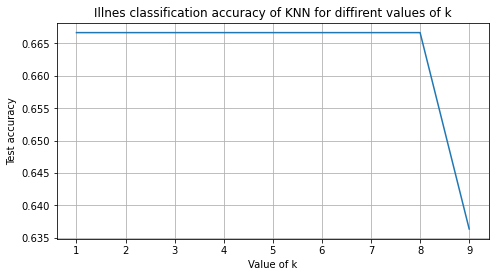

In [ ]:
from sklearn.metrics import accuracy_score
acc_list = []
acc_dict = {}
for i in range(1,10):
    acc_list.append(accuracy_score(y_test, make_knn_prediction(i)))
fig = plt.figure(figsize=(4, 3))
axes = fig.add_axes([0, 0, 1.5, 1])
axes.plot(range(1,10), acc_list)
axes.set_xlabel('Value of k')
axes.set_ylabel('Test accuracy')
axes.set_title('Illnes classification accuracy of KNN for diffirent values of k')
axes.grid(True)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


ValueError: could not broadcast input array from shape (100,2) into shape (100)

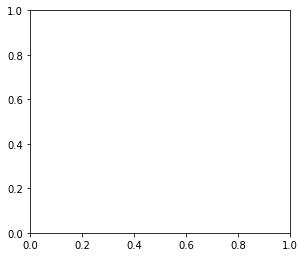

In [ ]:
### Idea from https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]
h = 0.2
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)
figure = plt.figure(figsize=(27, 9))
datasets = df_train

i = 1
ax = plt.subplot(2, 5, i)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])


X, y  = datasets[make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

for name, clf in zip(names, classifiers):
        ax = plt.subplot(2, 5, i)
        clf.fit(df_train, y_train)
        score = clf.score(df_test, y_test)
        print(xx)
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            print(xx)
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            print(xx)

        #Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(df_train[:,0], df_train[:,1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(df_test[:,0], df_test[:,], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        
        ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1


In [ ]:

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

for i, j in datasets:
    print(j)

[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 0 0
 1 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 1 1 1 0 1 0 1 0 0 0 1
 1 1 0 1 1 1 0 0 1 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0]
[1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 1 1 0 0
 1 0 0 1 1 1 0 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 1 1
 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0]
[1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 0 0 1 0 0 0 1 1 1 1 0 0 1 0
 0 0 0 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1
 1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1]


In [ ]:
def accuracy_matrix(prediction, answer):
    """Takes in the predictions of a model for a test-case, as well as the true values, 
    and returns a matrix of true and false for positive and negative cases."""
    total_sick = np.sum(answer)
    total_healthy = len(answer)-total_sick
    predictions_of_sick = answer[prediction == 1]
    predictions_of_healthy = answer[prediction == 0]
    if len(predictions_of_sick):
        true_positive = len(predictions_of_sick[predictions_of_sick == 1])/len(predictions_of_sick)
    else: 
        true_positive = 0
    false_positive = 1-true_positive
    if len(predictions_of_healthy):
        true_negative = len(predictions_of_healthy[predictions_of_healthy == 0])/len(predictions_of_healthy)
    else:
        true_negative = 0
    false_negative = 1-true_negative
    return true_positive, false_positive, true_negative, false_negative



In [ ]:
knn_predict = pd.DataFrame(columns = [ "true_positive", "false_positive", "true_negative", "false_negative"])
for i in range(1,9):
    gues = make_knn_prediction(i)
    true_positive, false_positive, true_negative, false_negative = accuracy_matrix(gues, y_test)
    knn_predict.loc[i-1] = [true_positive, false_positive,  true_negative, false_negative]
knn_predict


,true_positive,false_positive,true_negative,false_negative
0,0.5,0.5,0.689655,0.310345
1,0.5,0.5,0.677419,0.322581
2,0.5,0.5,0.689655,0.310345
3,0.5,0.5,0.677419,0.322581
4,0.5,0.5,0.677419,0.322581
5,0.0,1.0,0.666667,0.333333
6,0.0,1.0,0.666667,0.333333
7,0.0,1.0,0.666667,0.333333


In [ ]:
knn_predict = pd.DataFrame(columns = [ "true_positive", "false_positive", "true_negative", "false_negative"])
for i in [1, 10, 100]:
    gaus = GaussianProcessClassifier(max_iter_predict = i).fit(X = df_train, y = y_train)
    guess = gaus.predict(df_test)
    true_positive, false_positive, true_negative, false_negative = accuracy_matrix(guess, y_test)
    knn_predict.loc[i] = [true_positive, false_positive,  true_negative, false_negative]
knn_predict



,true_positive,false_positive,true_negative,false_negative
1,0.0,1.0,0.656250,0.343750
10,0.5,0.5,0.677419,0.322581
100,0.5,0.5,0.677419,0.322581


# Task 3: open question
Use the data to formulate, motivate, answer, and discuss another research question of your choice. You may use other data or features here, that we did not
cover

## Research Question: How effective is checking skin lesions for asymmetry, border, and colour in diagnosing Melanomas?

#### Cleaning the External Data
The data is cleaned based on resolution, blurriness, and contrast.

In [ ]:
df_test

array([[-1.16985054,  0.4497183 ],
       [-1.29039495, -0.6180586 ],
       [ 0.26082796, -0.03854727],
       [-0.00573968,  0.60061003],
       [-0.36547042, -0.26779379],
       [-1.18962735,  0.16189128],
       [ 1.49853067,  1.22521936],
       [-1.3045669 , -0.81982386],
       [-1.32734203, -0.51676929],
       [ 0.7076834 , -0.21439413],
       [ 2.61728371,  1.46839541],
       [-1.32209853, -0.69285025],
       [ 0.55110815, -1.41775756],
       [-1.22632066, -0.19879993],
       [-1.2103155 , -0.00399447],
       [-0.14761764, -0.96153266],
       [-1.31608442, -0.77434849],
       [-1.42853308,  1.75051522],
       [ 0.47014269, -0.41323003],
       [ 0.81644461, -0.14240489],
       [ 0.8202128 ,  0.12933134],
       [-1.22244389, -0.4347418 ],
       [ 0.2909625 ,  0.88714721],
       [-0.96531156, -0.37961425],
       [ 0.62038911, -0.3707064 ],
       [ 1.18273847,  1.35962237],
       [ 0.32254586,  0.39872868],
       [-1.37117164,  0.8647079 ],
       [ 2.19640346,

#### Predicting the Diagnosis

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6c6ff636-1d68-49e2-b04b-ee0d9895f3db' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>